In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.special import spherical_jn as j_l
from scipy.special import spherical_in as i_l
from spherical_bessel_zeros import Jn_zeros
from scipy.integrate import quadrature

In [2]:
l_big = 26
n_big = 26
a = 6.0  # Radius of the sphere

In [3]:
z_ln = Jn_zeros(l_big, n_big)  # Spherical Bessel zeros
z_nl = z_ln.T

E_nl = z_nl**2
E_max = E_nl[6-1, 0]
n_max = np.where(E_nl[:, 0] <= E_max)[0][-1] + 1
l_max = np.where(E_nl[0, :] <= E_max)[0][-1]
print(n_max, l_max)

6 13


In [4]:
def R_nl(n, l, r):
    return j_l(l, z_nl[n, l]*r/a)

def N_nl(n, l):
    # Normalization factor for LE basis functions
    def function_to_integrate_to_get_normalization_factor(x):
        return j_l(l, x)**2 * x**2
    integral, _ = sp.integrate.quadrature(function_to_integrate_to_get_normalization_factor, 0.0, z_nl[n, l])
    return (1.0/z_nl[n, l]**3 * integral)**(-0.5)

def get_LE_function_python(n, l, r):
    R = np.zeros_like(r)
    for i in range(r.shape[0]):
        R[i] = R_nl(n, l, r[i])
    return N_nl(n, l)*R*a**(-1.5)

In [5]:
# Feed LE (delta) radial spline points to Rust calculator:

n_spline_points = 101
spline_x = np.linspace(0.0, a, n_spline_points)  # x values

spline_f = []
for l in range(l_max+1):
    for n in range(n_max):
        spline_f_single = get_LE_function_python(n, l, spline_x)
        spline_f.append(spline_f_single)
spline_f = np.array(spline_f).T
spline_f = spline_f.reshape(n_spline_points, l_max+1, n_max)  # f(x) values

In [6]:
def get_LE_function_derivative(n, l, r):
    delta = 1e-6
    all_derivatives_except_at_zero = (get_LE_function_python(n, l, r[1:]+delta) - get_LE_function_python(n, l, r[1:]-delta)) / (2.0*delta)
    derivative_at_zero = (get_LE_function_python(n, l, np.array([delta/10.0])) - get_LE_function_python(n, l, np.array([0.0]))) / (delta/10.0)
    return np.concatenate([derivative_at_zero, all_derivatives_except_at_zero])

In [7]:
spline_df = []
for l in range(l_max+1):
    for n in range(n_max):
        spline_df_single = get_LE_function_derivative(n, l, spline_x)
        spline_df.append(spline_df_single)
spline_df = np.array(spline_df).T
spline_df = spline_df.reshape(n_spline_points, l_max+1, n_max)  # df/dx values

In [8]:
with open("splines.txt", "w") as file:
    np.savetxt(file, spline_x.flatten(), newline=" ")
    file.write("\n")

with open("splines.txt", "a") as file:
    np.savetxt(file, (1.0/(4.0*np.pi))*spline_f.flatten(), newline=" ")
    file.write("\n")
    np.savetxt(file, (1.0/(4.0*np.pi))*spline_df.flatten(), newline=" ")
    file.write("\n")

In [9]:
from rascaline import SphericalExpansion

hypers_spherical_expansion = {
        "cutoff": a,
        "max_radial": int(n_max),
        "max_angular": int(l_max),
        "center_atom_weight": 0.0,
        "radial_basis": {"Tabulated": {"file": "splines.txt"}},
        "atomic_gaussian_width": 100.0,
        "cutoff_function": {"Step": {}},
    }

calculator = SphericalExpansion(**hypers_spherical_expansion)

(100, 1, 6)


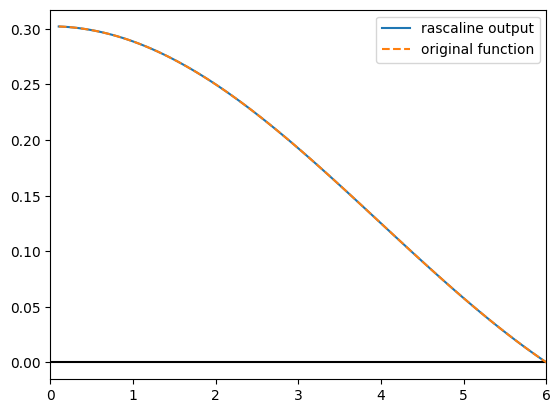

In [10]:
import ase
from equistore import TensorMap, TensorBlock, Labels

def get_dummy_structures(r_array):
    dummy_structures = []
    for r in r_array:
        dummy_structures.append(
            ase.Atoms('CH', positions=[(0, 0, 0), (0, 0, r)])
        )
    return dummy_structures 

# Create a fake list of dummy structures to test the radial functions generated from rascaline.

r = np.linspace(0.1, a-0.001, 100)
structures = get_dummy_structures(r)

spherical_expansion_coefficients = calculator.compute(structures)

block_C_0 = spherical_expansion_coefficients.block(species_center = 6, spherical_harmonics_l = 0, species_neighbor = 1)
print(block_C_0.values.shape)

block_C_0_0 = block_C_0.values[:, :, 0].flatten()
spherical_harmonics_0 = 1.0/np.sqrt(4.0*np.pi)


all_species = np.unique(spherical_expansion_coefficients.keys["species_center"])
all_neighbor_species = Labels(
        names=["species_neighbor"],
        values=np.array(all_species, dtype=np.int32).reshape(-1, 1),
    )
spherical_expansion_coefficients.keys_to_properties(all_neighbor_species)

plt.plot(r, block_C_0_0/spherical_harmonics_0, label="rascaline output")  # rascaline BUG?
plt.plot([0.0, a], [0.0, 0.0], "black")
plt.plot(r, get_LE_function_python(n=0, l=0, r=r), "--", label="original function")
plt.xlim(0.0, a)
plt.legend()
plt.show()

In [21]:
import torch

n_max_l = []
for l in range(l_max+1):
    n_max_l.append(np.where(E_nl[:, l] <= E_max)[0][-1]+1) 

def cut_to_LE(map: TensorMap, E_nl, E_max) -> TensorMap:
    LE_blocks = []
    for idx, block in map:
        l = idx[0]
        counter = 0
        for n in block.properties["n"]:
            if E_nl[n, l] <= E_max: counter += 1
        LE_values = torch.zeros((block.values.shape[0], block.values.shape[1], counter))
        counter_LE = 0
        counter_total = 0
        labels_LE = [] 
        for n in block.properties["n"]:
            if E_nl[n, l] <= E_max: 
                LE_values[:, :, counter_LE] = torch.tensor(block.values[:, :, counter_total])
                labels_LE.append([block.properties["species_neighbor"][counter_total], n, l])
                counter_LE += 1
            counter_total += 1
        LE_block = TensorBlock(
            values=LE_values,
            samples=block.samples,
            components=block.components,
            properties=Labels(
                names = ("a1", "n1", "l1"),
                values = np.array(labels_LE),
            ),
        )
        LE_blocks.append(LE_block)
    return TensorMap(
            keys = Labels(
                names = ("lambda", "a_i"),
                values = map.keys.asarray(),
            ),
            blocks = LE_blocks
        )

spherical_LE = cut_to_LE(spherical_expansion_coefficients, E_nl, E_max)
print("??")

print(spherical_LE)

??
TensorMap with 28 blocks
keys: ['spherical_harmonics_l' 'species_center']
                  0                   1
                  1                   1
                  2                   1
                  3                   1
                  4                   1
                  5                   1
                  6                   1
                  7                   1
                  8                   1
                  9                   1
                 10                   1
                 11                   1
                 12                   1
                 13                   1
                  0                   6
                  1                   6
                  2                   6
                  3                   6
                  4                   6
                  5                   6
                  6                   6
                  7                   6
                  8                   6
   